# Some topic coherence use cases

In [33]:
import operator
from collections import namedtuple

from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
texts = [['human', 'interface', 'computer'],
         ['survey', 'user', 'computer', 'system', 'response', 'time'],
         ['eps', 'user', 'interface', 'system'],
         ['system', 'human', 'system', 'eps'],
         ['user', 'response', 'time'],
         ['trees'],
         ['graph', 'trees'],
         ['graph', 'minors', 'trees'],
         ['graph', 'minors', 'survey']]

In [5]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

### Finding out the optimal number of topics

In [6]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list

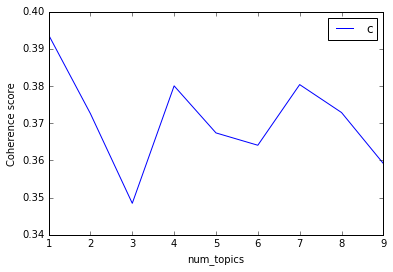

In [9]:
lm_list = evaluate_graph(dictionary, corpus, texts, 10)

As we can see, 2 would be the best choice for the number of topics which is also the correct value since this corpus was designed to 2 topics, namely "Human-Computer interaction" and "Graphs and trees". Hence, just select `lm_list[1]` for your LdaModel

### Making LDA behave like LSI
Here we just have 2 topics however, the same approach can be used for multiple topics.

In [10]:
lm = lm_list[1]

In [13]:
lm.show_topics(formatted=False)

[(0,
  [(u'user', 0.14710733043762769),
   (u'system', 0.11091383992680816),
   (u'response', 0.10774688179113835),
   (u'time', 0.10233047821720406),
   (u'trees', 0.087948794803798927),
   (u'graph', 0.079485146451697894),
   (u'survey', 0.07526115085274368),
   (u'interface', 0.074644398934470682),
   (u'eps', 0.069599948233048423),
   (u'computer', 0.058999396488198623)]),
 (1,
  [(u'system', 0.13282887492911646),
   (u'graph', 0.11537522576174111),
   (u'human', 0.11181322589854704),
   (u'trees', 0.10703405658911989),
   (u'minors', 0.094033312724915177),
   (u'computer', 0.087136990647558726),
   (u'eps', 0.076689841646505566),
   (u'interface', 0.071718390218816486),
   (u'survey', 0.071110563443194746),
   (u'user', 0.048731616175960051)])]

In [15]:
coherence_values = {}
for n, topic in lm.show_topics(formatted=False):
    topic = [word for word, _ in topic]
    cm = CoherenceModel(topics=[topic], texts=texts, dictionary=dictionary, window_size=2)
    coherence_values[n] = cm.get_coherence()

Sorting in decreasing order of coherence values for ranking

In [18]:
print sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)

[(0, 0.40844152859807636), (1, 0.3367503796800731)]


### Making your own coherence pipeline
Let's modify `c_uci` to use `s_one_pre` instead of `s_one_one` segmentation

In [34]:
from gensim.topic_coherence import (segmentation, probability_estimation,
                                    direct_confirmation_measure, indirect_confirmation_measure,
                                    aggregation)
from gensim.matutils import argsort

In [24]:
make_pipeline = namedtuple('Coherence_Measure', 'seg, prob, conf, aggr')

In [28]:
measure = make_pipeline(segmentation.s_one_one,
                        probability_estimation.p_boolean_sliding_window,
                        direct_confirmation_measure.log_ratio_measure,
                        aggregation.arithmetic_mean)

To get topics out of the topic model

In [35]:
topics = []
for topic in lm.state.get_lambda():
    bestn = argsort(topic, topn=10, reverse=True)
topics.append(bestn)

In [37]:
# Perform segmentation
segmented_topics = measure.seg(topics)

In [38]:
# Since this is a window-based coherence measure we will perform window based prob estimation
per_topic_postings, num_windows = measure.prob(texts=texts, segmented_topics=segmented_topics,
                                               dictionary=dictionary, window_size=2)

In [39]:
confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_windows, normalize=False)

In [40]:
print measure.aggr(confirmed_measures)

-16.2529427009
